In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import time


In [ ]:
# Data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load training and test datasets
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define the size for the validation set (e.g., 20% of the training data)
val_size = int(len(train_data) * 0.2)  # 20% for validation
train_size = len(train_data) - val_size  # Remaining 80% for training

# Split the training data into training and validation datasets
train_data, val_data = random_split(train_data, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)  # Validation loader
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


## Implement a MLP



In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # fully-connected layers
        self.str1 = nn.Linear(28 * 28, 128)  # Input layer to first hidden layer
        self.str2 = nn.Linear(128, 64)        # First hidden layer to second hidden layer
        self.str3 = nn.Linear(64, 10)         # Second hidden layer to output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = torch.relu(self.str1(x))  # Activation for first hidden layer
        x = torch.relu(self.str2(x))  # Activation for second hidden layer
        x = self.str3(x)             # Output layer
        return x

In [5]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    losses = []
    accuracies = []
    losses_val = []
    accuracies_val = []
    epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time() # Save the start time of training
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()           # Reseted gradients to zero
            outputs = model(inputs)         # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()                 # Call backpropagation function for loss object
            optimizer.step()                # Optimizer updates parameters

            running_loss += loss.item()     # Accumulate loss for each batch
            _, predicted = outputs.max(1)   # Get predictions
            total += labels.size(0)         # Total samples
            correct += predicted.eq(labels).sum().item()  # Correct predictions, .item extract scalar value from .sum tensor

        train_loss = running_loss / len(train_loader)  # Average training loss
        train_acc = 100. * correct / total              # Training accuracy

        losses.append(train_loss)
        accuracies.append(train_acc)

        model.eval() # Set the model to evaluate mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Temporarily disable gradients computations during validation
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total
        losses_val.append(val_loss)
        accuracies_val.append(val_acc)
        epoch_times.append(time.time() - start_time)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return model, losses, accuracies, losses_val, accuracies_val, epoch_times

In [6]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    loss /= len(data_loader)
    accuracy = 100. * correct / total
    return accuracy



## Gradient descent

In [28]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)  # SGD optimizer

# Train the model
trained_model, train_losses, train_accuracies, val_losses, val_accuracies, _ = train_model(model, train_loader,val_loader, criterion, optimizer, num_epochs=30)

Epoch [1/30], Train Loss: 2.2468, Train Acc: 24.14%, Val Loss: 2.1817, Val Acc: 34.42%
Epoch [2/30], Train Loss: 2.0872, Train Acc: 44.36%, Val Loss: 1.9694, Val Acc: 52.25%
Epoch [3/30], Train Loss: 1.8130, Train Acc: 57.45%, Val Loss: 1.6305, Val Acc: 63.31%
Epoch [4/30], Train Loss: 1.4450, Train Acc: 68.22%, Val Loss: 1.2579, Val Acc: 73.83%
Epoch [5/30], Train Loss: 1.1121, Train Acc: 76.10%, Val Loss: 0.9739, Val Acc: 78.83%
Epoch [6/30], Train Loss: 0.8805, Train Acc: 80.23%, Val Loss: 0.7903, Val Acc: 82.20%
Epoch [7/30], Train Loss: 0.7326, Train Acc: 82.50%, Val Loss: 0.6742, Val Acc: 83.45%
Epoch [8/30], Train Loss: 0.6369, Train Acc: 84.10%, Val Loss: 0.5959, Val Acc: 85.12%
Epoch [9/30], Train Loss: 0.5710, Train Acc: 85.32%, Val Loss: 0.5413, Val Acc: 85.89%
Epoch [10/30], Train Loss: 0.5233, Train Acc: 86.19%, Val Loss: 0.5010, Val Acc: 86.72%
Epoch [11/30], Train Loss: 0.4877, Train Acc: 86.93%, Val Loss: 0.4709, Val Acc: 87.26%
Epoch [12/30], Train Loss: 0.4603, Train 

In [29]:
def plot_training_results(losses, accuracies, epochs=30):
    """
    Plots training loss and accuracy over epochs.

    Parameters:
        losses (list): A list of loss values per epoch.
        accuracies (list): A list of accuracy values per epoch.
        epochs (int): Total number of epochs (default is 50).
    """
    plt.figure(figsize=(16, 8))  # Set figure size

    # Plot Loss
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.plot(range(1, epochs + 1), losses, marker='o', label='Loss', color='blue')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, epochs + 1, max(epochs // 10, 1)))  # Adjust x-ticks based on epochs
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.plot(range(1, epochs + 1), accuracies, marker='o', label='Accuracy', color='green')
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(1, epochs + 1, max(epochs // 10, 1)))  # Adjust x-ticks based on epochs
    plt.legend()

    # Show plots
    plt.tight_layout()  # Automatically adjust layout to prevent overlap
    plt.show()

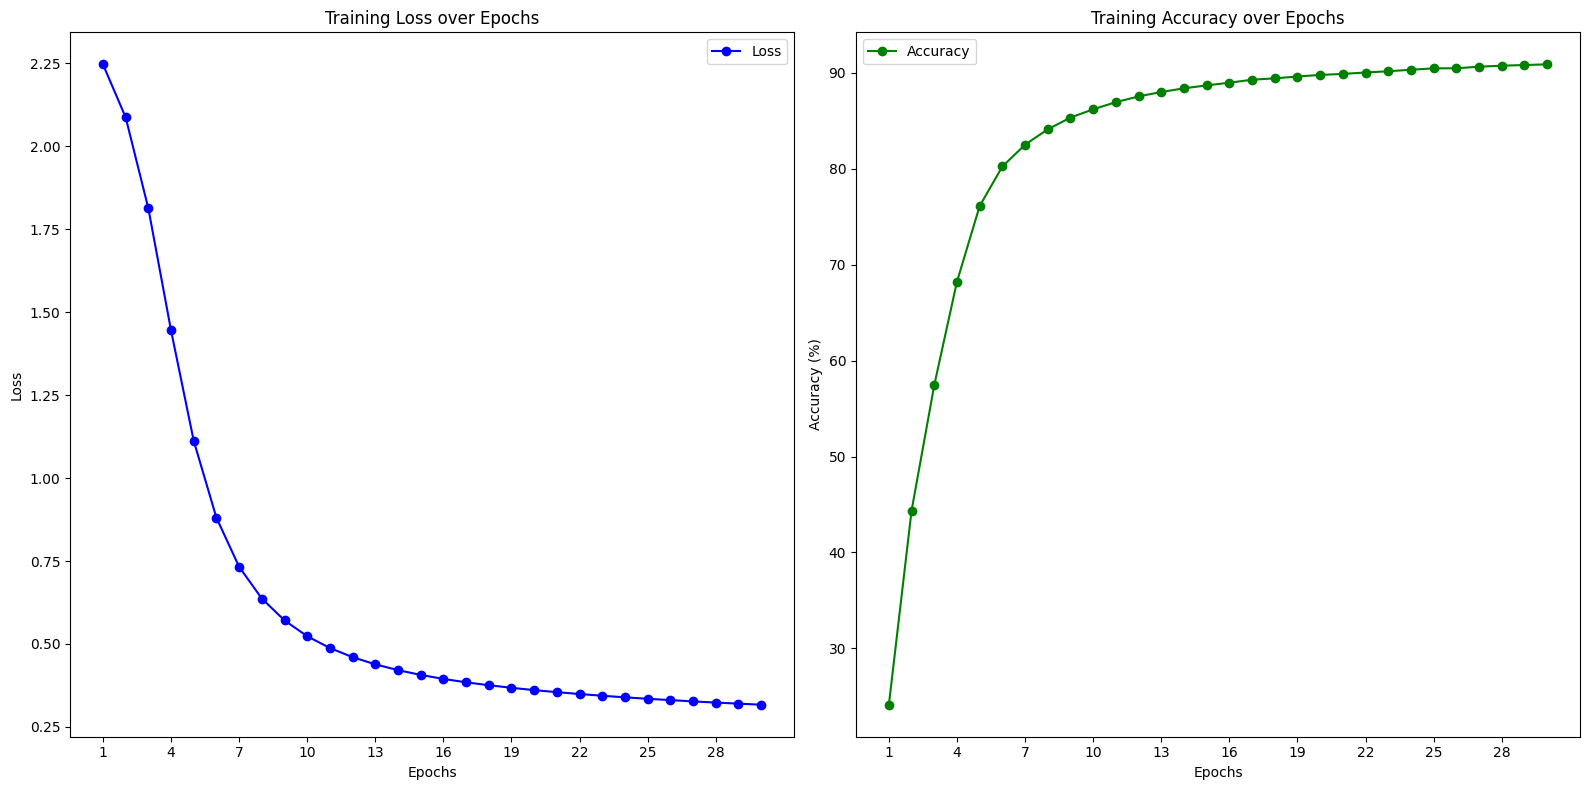

In [30]:
# Plotting the results
plot_training_results(train_losses, train_accuracies, epochs=30)


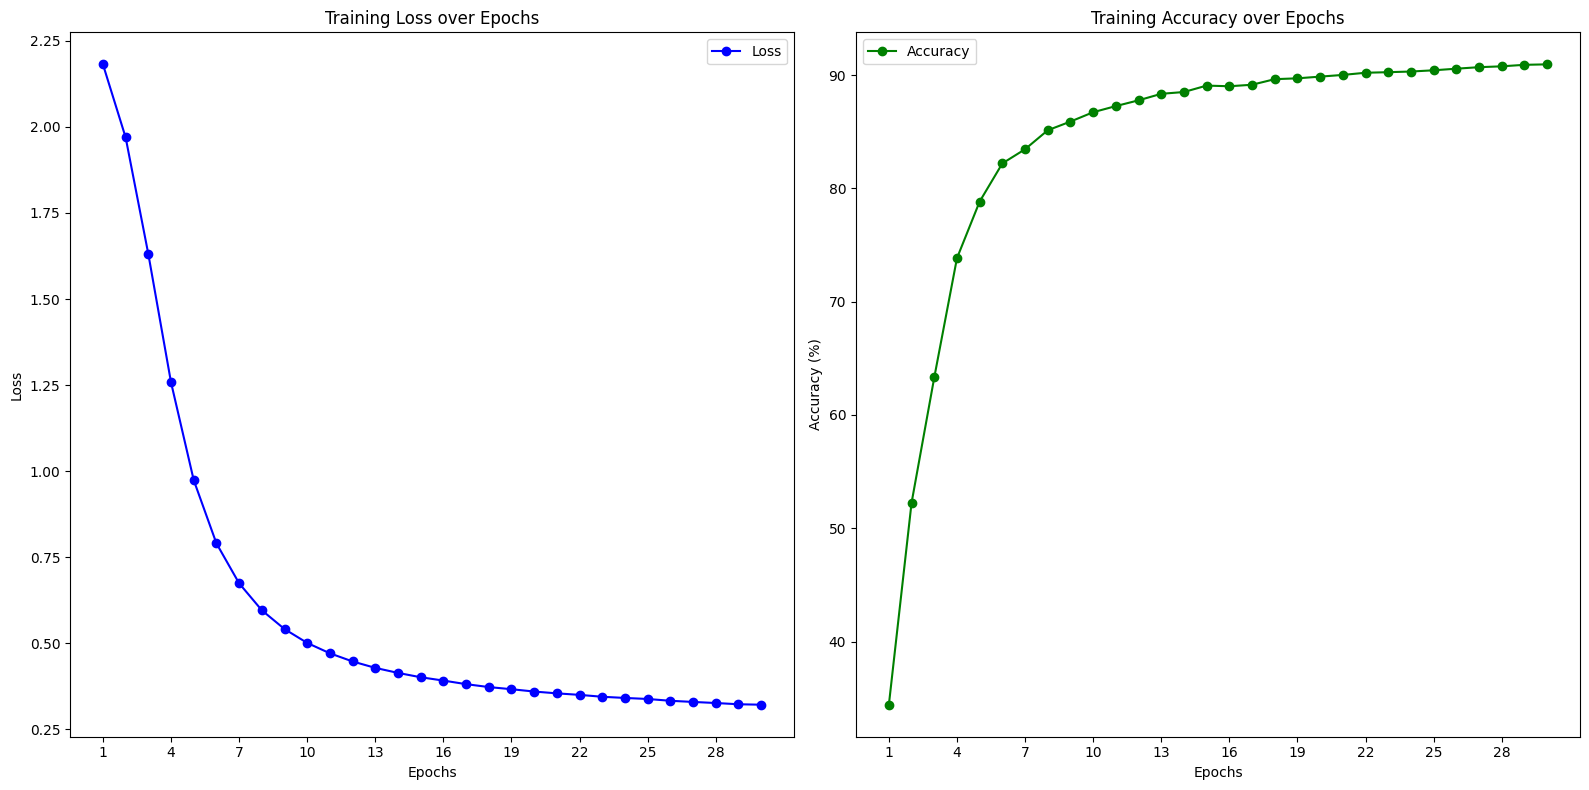

In [31]:
# Plotting the results validation
plot_training_results(val_losses, val_accuracies, epochs=30)


In [21]:
# Test the model
test_acc = evaluate_model(trained_model, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 91.20%


## Implement gradient descent with incorporated momentum.

In [22]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Train the model
trained_model, train_losses, train_accuracies, val_losses, val_accuracies, _ = train_model(model, train_loader,val_loader, criterion, optimizer, num_epochs=30)

Epoch [1/30], Train Loss: 0.4340, Train Acc: 87.25%, Val Loss: 0.2465, Val Acc: 93.01%
Epoch [2/30], Train Loss: 0.2136, Train Acc: 93.50%, Val Loss: 0.1900, Val Acc: 94.28%
Epoch [3/30], Train Loss: 0.1562, Train Acc: 95.25%, Val Loss: 0.1631, Val Acc: 95.19%
Epoch [4/30], Train Loss: 0.1234, Train Acc: 96.16%, Val Loss: 0.1198, Val Acc: 96.50%
Epoch [5/30], Train Loss: 0.1073, Train Acc: 96.68%, Val Loss: 0.1294, Val Acc: 96.04%
Epoch [6/30], Train Loss: 0.0901, Train Acc: 97.15%, Val Loss: 0.1259, Val Acc: 96.37%
Epoch [7/30], Train Loss: 0.0806, Train Acc: 97.45%, Val Loss: 0.1074, Val Acc: 97.00%
Epoch [8/30], Train Loss: 0.0701, Train Acc: 97.78%, Val Loss: 0.1152, Val Acc: 96.58%
Epoch [9/30], Train Loss: 0.0652, Train Acc: 97.86%, Val Loss: 0.0984, Val Acc: 97.21%
Epoch [10/30], Train Loss: 0.0590, Train Acc: 98.10%, Val Loss: 0.0984, Val Acc: 97.28%
Epoch [11/30], Train Loss: 0.0531, Train Acc: 98.27%, Val Loss: 0.1079, Val Acc: 96.98%
Epoch [12/30], Train Loss: 0.0496, Train 

In [23]:
def plot_training_results(losses, accuracies, epochs=30):
    """
    Plots training loss and accuracy over epochs.

    Parameters:
        losses (list): A list of loss values per epoch.
        accuracies (list): A list of accuracy values per epoch.
        epochs (int): Total number of epochs (default is 50).
    """
    plt.figure(figsize=(16, 8))  # Set figure size

    # Plot Loss
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.plot(range(1, epochs + 1), losses, marker='o', label='Loss', color='blue')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, epochs + 1, max(epochs // 10, 1)))  # Adjust x-ticks based on epochs
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.plot(range(1, epochs + 1), accuracies, marker='o', label='Accuracy', color='pink')
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(1, epochs + 1, max(epochs // 10, 1)))  # Adjust x-ticks based on epochs
    plt.legend()

    # Show plots
    plt.tight_layout()  # Automatically adjust layout to prevent overlap
    plt.show()

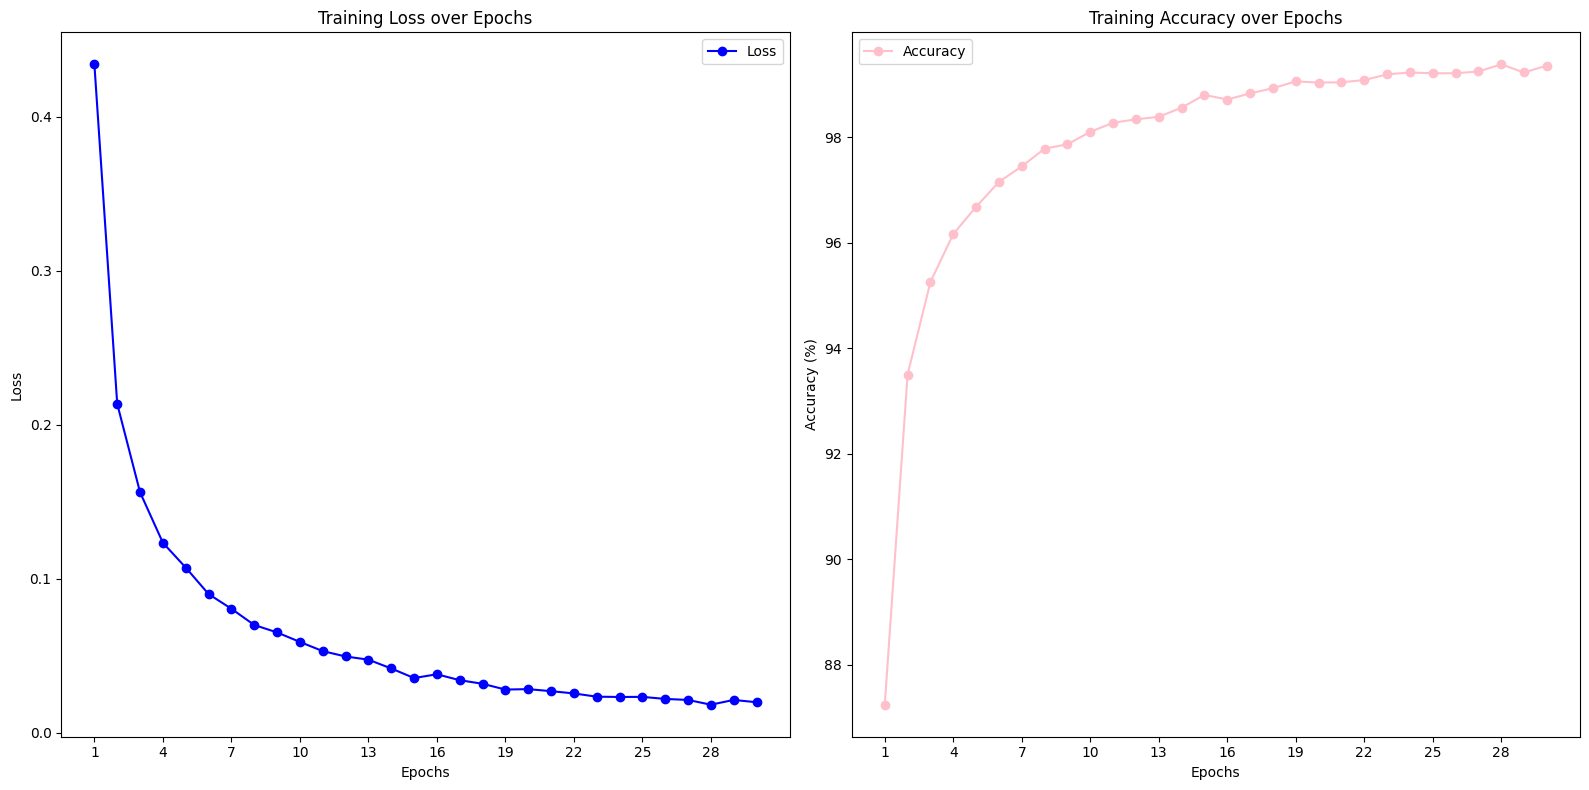

In [24]:
# Plotting the results
plot_training_results(train_losses, train_accuracies, epochs=30)

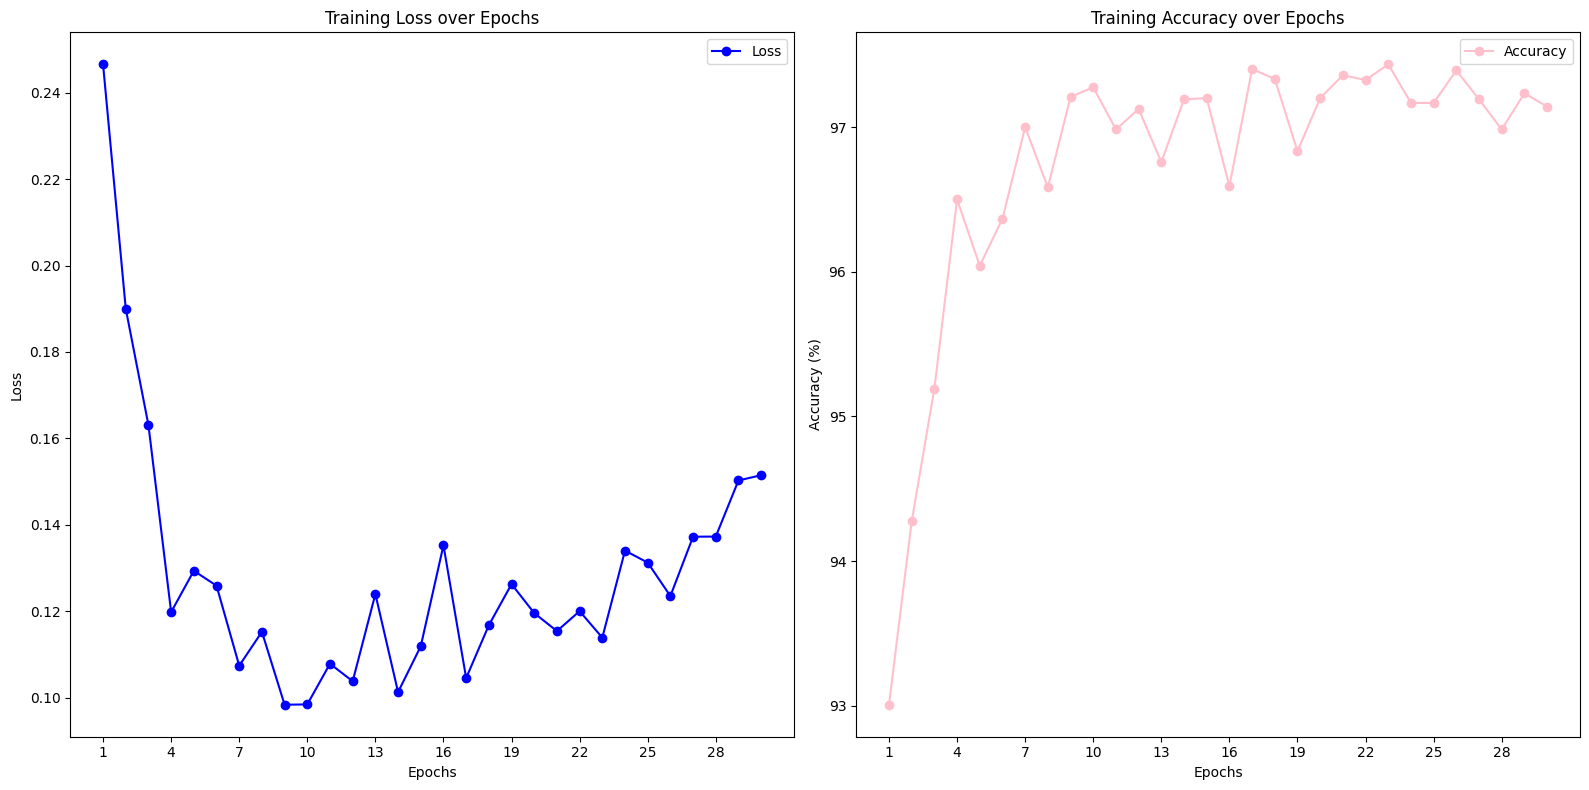

In [25]:
# Plotting the results validation
plot_training_results(val_losses, val_accuracies, epochs=30)

## Implement gradient descent with manually added momentum.

In [ ]:
model_momentum = MLP()

# Define loss function and optimizer with momentum
criterion = nn.CrossEntropyLoss()
momentum = 0.9  # Values between 0 and 1
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=momentum)  # SGD optimizer with momentum

# Train the model
trained_model_momentum, train_losses_mom, train_accuracies_mom, val_losses_mom, val_accuracies_mom, _ = train_model(model, train_loader,val_loader, criterion, optimizer, num_epochs=30)


Epoch [1/30], Train Loss: 0.2662, Train Acc: 92.22%, Val Loss: 0.2695, Val Acc: 91.97%
Epoch [2/30], Train Loss: 0.2499, Train Acc: 92.59%, Val Loss: 0.2483, Val Acc: 92.78%
Epoch [3/30], Train Loss: 0.2338, Train Acc: 93.17%, Val Loss: 0.2319, Val Acc: 93.33%
Epoch [4/30], Train Loss: 0.2186, Train Acc: 93.66%, Val Loss: 0.2255, Val Acc: 93.56%
Epoch [5/30], Train Loss: 0.2045, Train Acc: 94.09%, Val Loss: 0.2087, Val Acc: 94.06%
Epoch [6/30], Train Loss: 0.1915, Train Acc: 94.44%, Val Loss: 0.1963, Val Acc: 94.37%
Epoch [7/30], Train Loss: 0.1803, Train Acc: 94.78%, Val Loss: 0.1920, Val Acc: 94.23%
Epoch [8/30], Train Loss: 0.1692, Train Acc: 95.15%, Val Loss: 0.1801, Val Acc: 94.76%
Epoch [9/30], Train Loss: 0.1602, Train Acc: 95.47%, Val Loss: 0.1807, Val Acc: 94.61%
Epoch [10/30], Train Loss: 0.1511, Train Acc: 95.66%, Val Loss: 0.1652, Val Acc: 95.15%
Epoch [11/30], Train Loss: 0.1433, Train Acc: 95.85%, Val Loss: 0.1584, Val Acc: 95.30%
Epoch [12/30], Train Loss: 0.1364, Train 

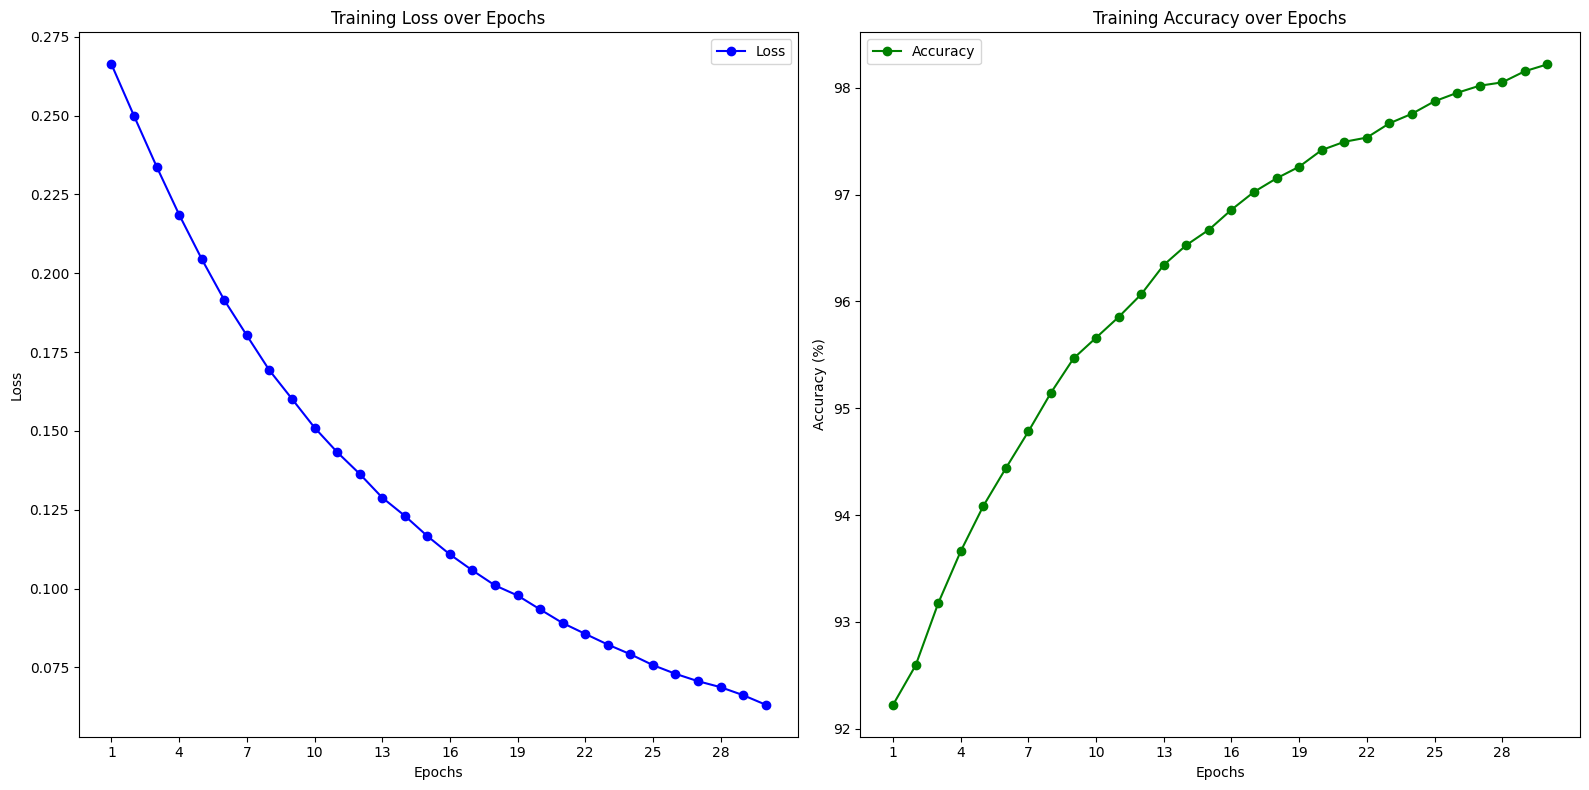

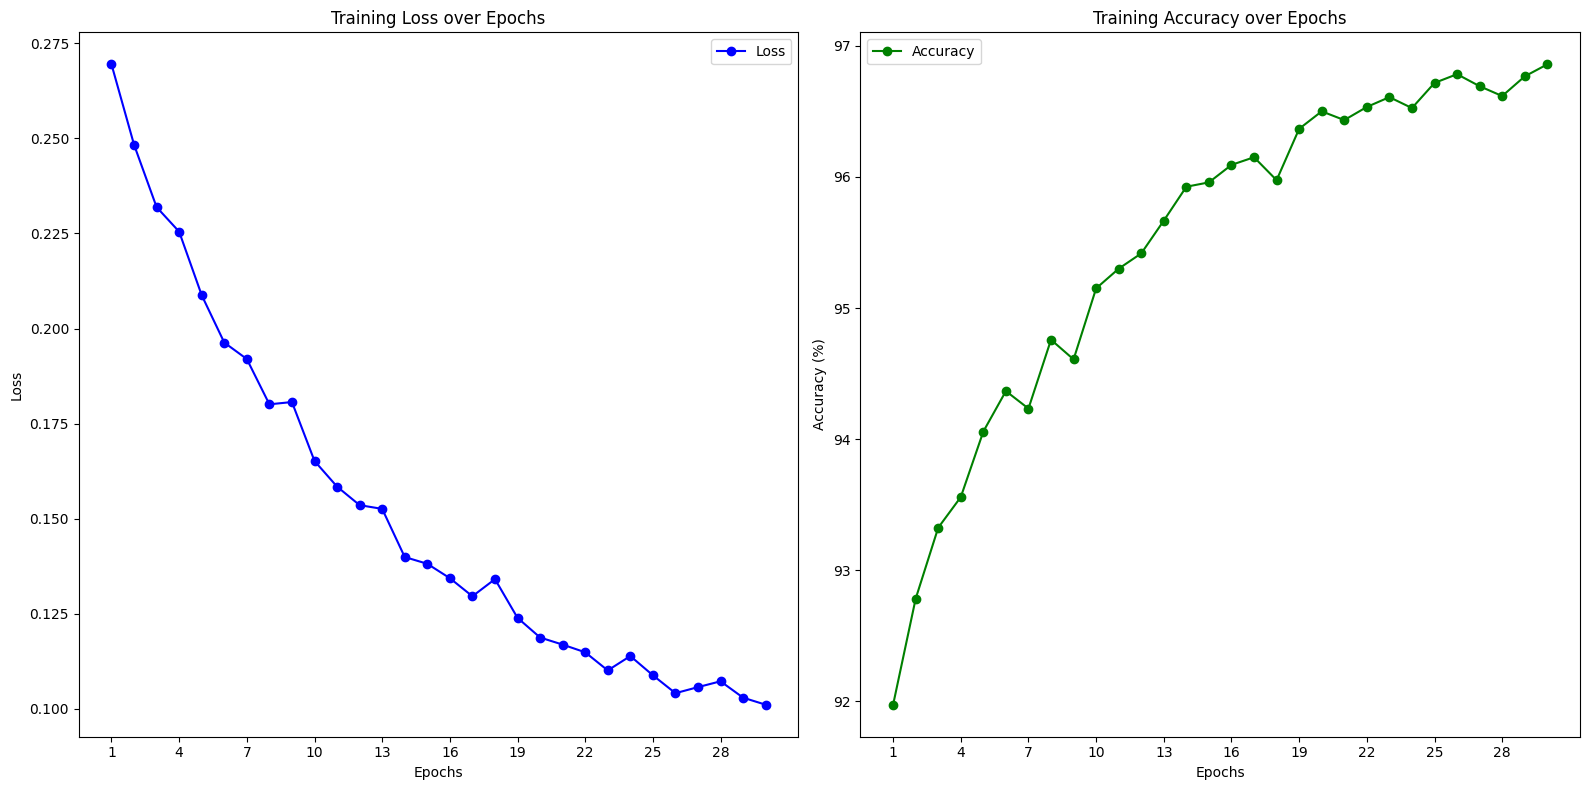

In [ ]:
# Plotting the train  results
plot_training_results(train_losses_mom, train_accuracies_mom, epochs=30)

# Plotting the validation results
plot_training_results(val_losses_mom, val_accuracies_mom, epochs=30)


In [ ]:
# Evaluare pe setul de testare
test_accuracy = evaluate_model(trained_model_momentum, test_loader, criterion)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 97.07%


## Comparison between optimizers

In [ ]:
import time

results = {
    'SGD': {'time': None, 'accuracy': None},
    'Adam': {'time': None, 'accuracy': None}
}

# Experiment with SGD
model_sgd = MLP()  # Reset the model for new training
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

start_time = time.time()

model_sgd,train_losses_sgd, train_accuracies_sgd, val_losses_sgd, val_accuracies_sgd, _= train_model(model_sgd, train_loader,val_loader, criterion, optimizer_sgd, num_epochs=30)

results['SGD']['time'] = time.time() - start_time
results['SGD']['accuracy'] = evaluate_model(model_sgd, test_loader, criterion)



Epoch [1/30], Train Loss: 1.1801, Train Acc: 68.47%, Val Loss: 0.4870, Val Acc: 86.80%
Epoch [2/30], Train Loss: 0.4119, Train Acc: 88.38%, Val Loss: 0.3543, Val Acc: 89.80%
Epoch [3/30], Train Loss: 0.3405, Train Acc: 90.12%, Val Loss: 0.3365, Val Acc: 89.99%
Epoch [4/30], Train Loss: 0.3086, Train Acc: 90.99%, Val Loss: 0.2951, Val Acc: 91.42%
Epoch [5/30], Train Loss: 0.2854, Train Acc: 91.63%, Val Loss: 0.2779, Val Acc: 91.92%
Epoch [6/30], Train Loss: 0.2656, Train Acc: 92.36%, Val Loss: 0.2618, Val Acc: 92.25%
Epoch [7/30], Train Loss: 0.2478, Train Acc: 92.79%, Val Loss: 0.2511, Val Acc: 92.44%
Epoch [8/30], Train Loss: 0.2309, Train Acc: 93.36%, Val Loss: 0.2305, Val Acc: 93.22%
Epoch [9/30], Train Loss: 0.2150, Train Acc: 93.83%, Val Loss: 0.2236, Val Acc: 93.20%
Epoch [10/30], Train Loss: 0.2018, Train Acc: 94.10%, Val Loss: 0.2051, Val Acc: 93.87%
Epoch [11/30], Train Loss: 0.1884, Train Acc: 94.59%, Val Loss: 0.1942, Val Acc: 94.33%
Epoch [12/30], Train Loss: 0.1777, Train 

In [ ]:
# Experiment with Adam
model_adam = MLP()  # Reset the model for new training
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

start_time = time.time()
model_adam, train_losses_adam, train_accuracies_adam, val_losses_adam, val_accuracies_adam, _= train_model(model_adam, train_loader, val_loader, criterion, optimizer_adam, num_epochs=30)
results['Adam']['time'] = time.time() - start_time
results['Adam']['accuracy'] = evaluate_model(model_adam, test_loader, criterion)

Epoch [1/30], Train Loss: 0.4155, Train Acc: 87.66%, Val Loss: 0.2443, Val Acc: 92.90%
Epoch [2/30], Train Loss: 0.2048, Train Acc: 93.83%, Val Loss: 0.1641, Val Acc: 95.14%
Epoch [3/30], Train Loss: 0.1430, Train Acc: 95.71%, Val Loss: 0.1655, Val Acc: 95.18%
Epoch [4/30], Train Loss: 0.1182, Train Acc: 96.42%, Val Loss: 0.1335, Val Acc: 95.92%
Epoch [5/30], Train Loss: 0.0995, Train Acc: 96.94%, Val Loss: 0.1124, Val Acc: 96.58%
Epoch [6/30], Train Loss: 0.0853, Train Acc: 97.38%, Val Loss: 0.1166, Val Acc: 96.38%
Epoch [7/30], Train Loss: 0.0795, Train Acc: 97.48%, Val Loss: 0.1242, Val Acc: 96.30%
Epoch [8/30], Train Loss: 0.0675, Train Acc: 97.88%, Val Loss: 0.1146, Val Acc: 96.42%
Epoch [9/30], Train Loss: 0.0627, Train Acc: 97.89%, Val Loss: 0.1056, Val Acc: 96.94%
Epoch [10/30], Train Loss: 0.0582, Train Acc: 98.11%, Val Loss: 0.1089, Val Acc: 96.72%
Epoch [11/30], Train Loss: 0.0496, Train Acc: 98.42%, Val Loss: 0.1238, Val Acc: 96.38%
Epoch [12/30], Train Loss: 0.0483, Train 

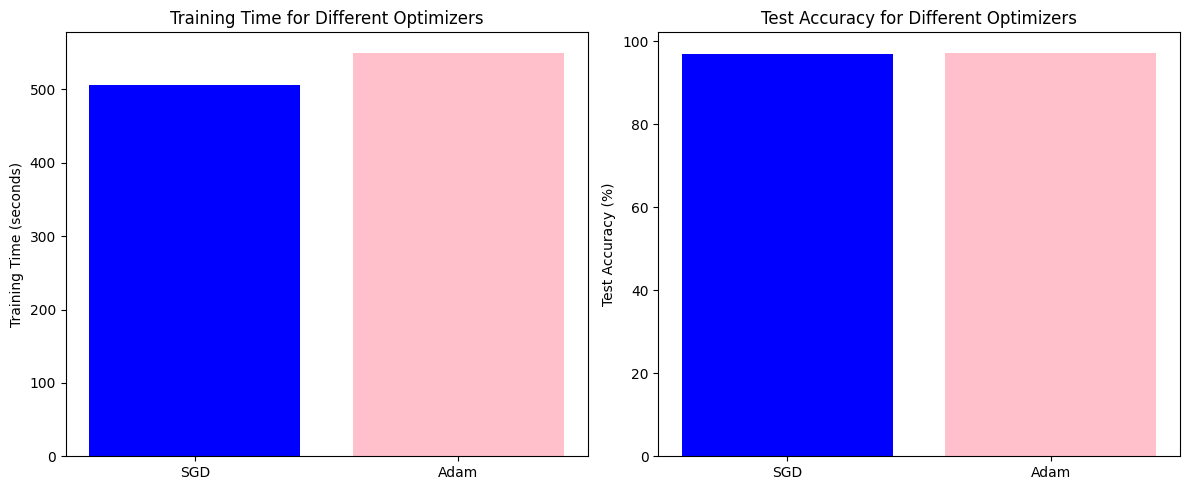

In [ ]:
# Plotting results

optimizers = list(results.keys())
training_times = [results[opt]['time'] for opt in optimizers]
accuracies = [results[opt]['accuracy'] for opt in optimizers]

plt.figure(figsize=(12, 5))

# Plot training time
plt.subplot(1, 2, 1)
plt.bar(optimizers, training_times, color=['blue', 'pink'])
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Different Optimizers')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.bar(optimizers, accuracies, color=['blue', 'pink'])
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy for Different Optimizers')

plt.tight_layout()
plt.show()

## Regularization Techniques

In [ ]:
class MLP_Dropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(MLP_Dropout, self).__init__()
        self.str1 = nn.Linear(28 * 28, 128)
        self.dropout = nn.Dropout(dropout_rate) # 50% of neurons will be randomly dropped out during each forward pass
        self.str2 = nn.Linear(128, 64)
        self.str3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.str1(x))
        x = self.dropout(x)
        x = torch.relu(self.str2(x))
        x = self.str3(x)
        return x

In [ ]:
# Initialize the model with Dropout
dropout_model = MLP_Dropout(dropout_rate=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dropout_model.parameters(), lr=0.001)

# Train model
dropout_model, dropout_train_losses, dropout_train_accuracies, dropout_val_losses, dropout_val_accuracies, _ = train_model(dropout_model, train_loader,val_loader, criterion, optimizer, num_epochs=30)


Epoch [1/30], Train Loss: 0.6315, Train Acc: 80.00%, Val Loss: 0.2912, Val Acc: 91.03%
Epoch [2/30], Train Loss: 0.3765, Train Acc: 88.34%, Val Loss: 0.2215, Val Acc: 93.24%
Epoch [3/30], Train Loss: 0.3325, Train Acc: 89.76%, Val Loss: 0.1954, Val Acc: 94.03%
Epoch [4/30], Train Loss: 0.3079, Train Acc: 90.43%, Val Loss: 0.1878, Val Acc: 94.37%
Epoch [5/30], Train Loss: 0.2870, Train Acc: 91.04%, Val Loss: 0.1760, Val Acc: 94.62%
Epoch [6/30], Train Loss: 0.2704, Train Acc: 91.53%, Val Loss: 0.1596, Val Acc: 95.12%
Epoch [7/30], Train Loss: 0.2641, Train Acc: 91.82%, Val Loss: 0.1516, Val Acc: 95.37%
Epoch [8/30], Train Loss: 0.2539, Train Acc: 92.04%, Val Loss: 0.1439, Val Acc: 95.56%
Epoch [9/30], Train Loss: 0.2496, Train Acc: 92.21%, Val Loss: 0.1423, Val Acc: 95.57%
Epoch [10/30], Train Loss: 0.2367, Train Acc: 92.53%, Val Loss: 0.1412, Val Acc: 95.58%
Epoch [11/30], Train Loss: 0.2306, Train Acc: 92.75%, Val Loss: 0.1381, Val Acc: 95.70%
Epoch [12/30], Train Loss: 0.2322, Train 

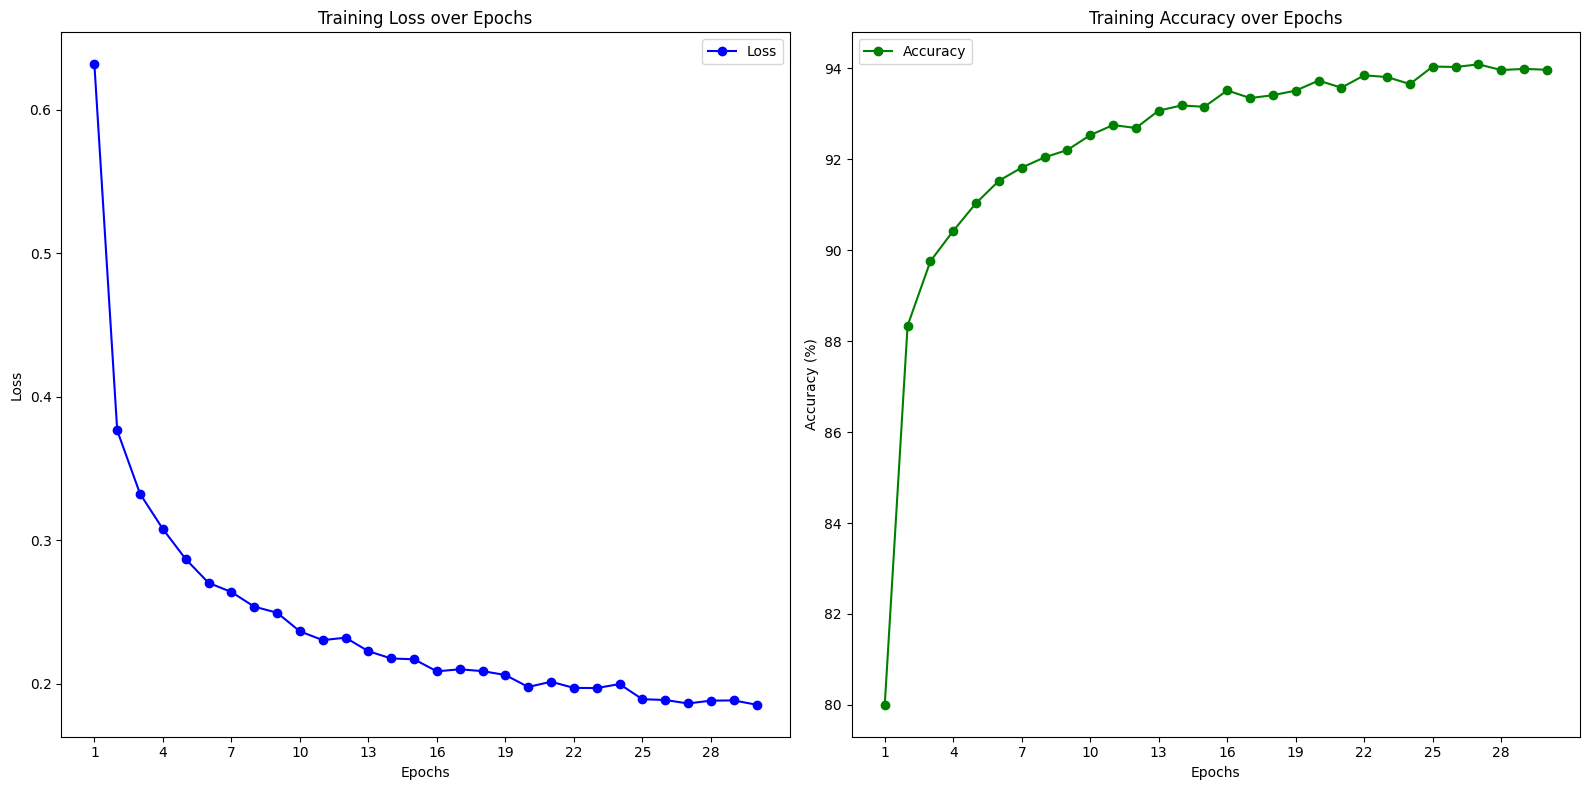

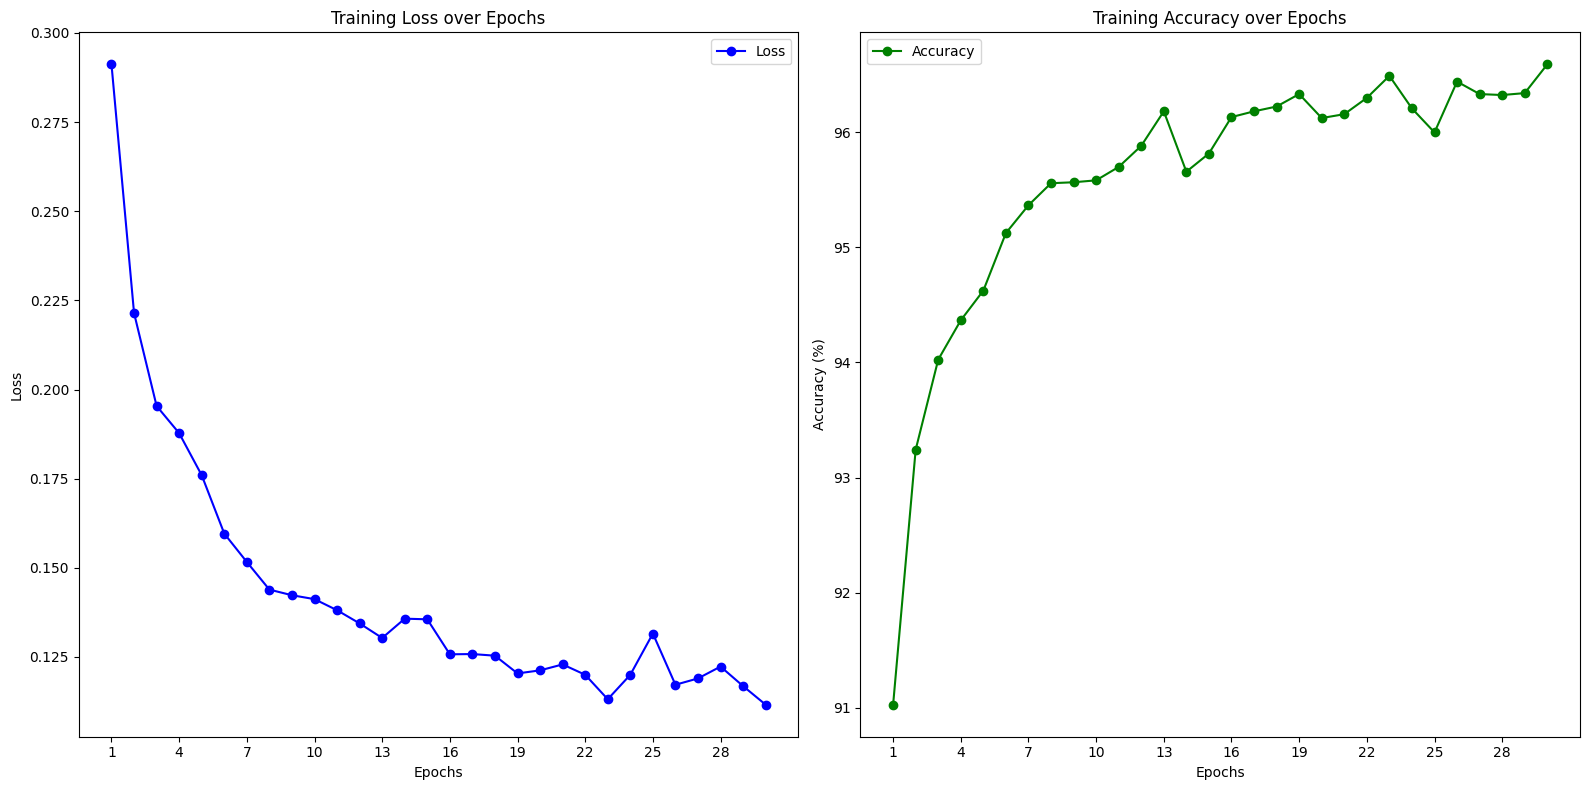

In [ ]:
plot_training_results(dropout_train_losses, dropout_train_accuracies, epochs=30)
plot_training_results(dropout_val_losses, dropout_val_accuracies, epochs=30)

In [ ]:
evaluate_model(dropout_model, test_loader, criterion)

96.86

In [ ]:
# Initialize the model with L2 regularization
L2reg_model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(L2reg_model.parameters(), lr=0.001, weight_decay=1e-4) # applied penalty term

# Train the model
L2reg_model, L2reg_train_losses, L2reg_train_accuracies,L2reg_val_losses, L2reg_val_accuracies, _ = train_model(L2reg_model, train_loader,val_loader, criterion, optimizer, num_epochs=30)


Epoch [1/30], Train Loss: 0.3995, Train Acc: 87.88%, Val Loss: 0.2314, Val Acc: 93.41%
Epoch [2/30], Train Loss: 0.1957, Train Acc: 94.04%, Val Loss: 0.1962, Val Acc: 93.78%
Epoch [3/30], Train Loss: 0.1494, Train Acc: 95.41%, Val Loss: 0.1674, Val Acc: 95.07%
Epoch [4/30], Train Loss: 0.1229, Train Acc: 96.18%, Val Loss: 0.1319, Val Acc: 96.02%
Epoch [5/30], Train Loss: 0.1060, Train Acc: 96.72%, Val Loss: 0.1204, Val Acc: 96.17%
Epoch [6/30], Train Loss: 0.0949, Train Acc: 96.99%, Val Loss: 0.1094, Val Acc: 96.78%
Epoch [7/30], Train Loss: 0.0847, Train Acc: 97.38%, Val Loss: 0.1318, Val Acc: 95.91%
Epoch [8/30], Train Loss: 0.0778, Train Acc: 97.57%, Val Loss: 0.1029, Val Acc: 96.90%
Epoch [9/30], Train Loss: 0.0751, Train Acc: 97.61%, Val Loss: 0.1129, Val Acc: 96.56%
Epoch [10/30], Train Loss: 0.0715, Train Acc: 97.70%, Val Loss: 0.1197, Val Acc: 96.33%
Epoch [11/30], Train Loss: 0.0646, Train Acc: 97.87%, Val Loss: 0.1466, Val Acc: 95.88%
Epoch [12/30], Train Loss: 0.0615, Train 

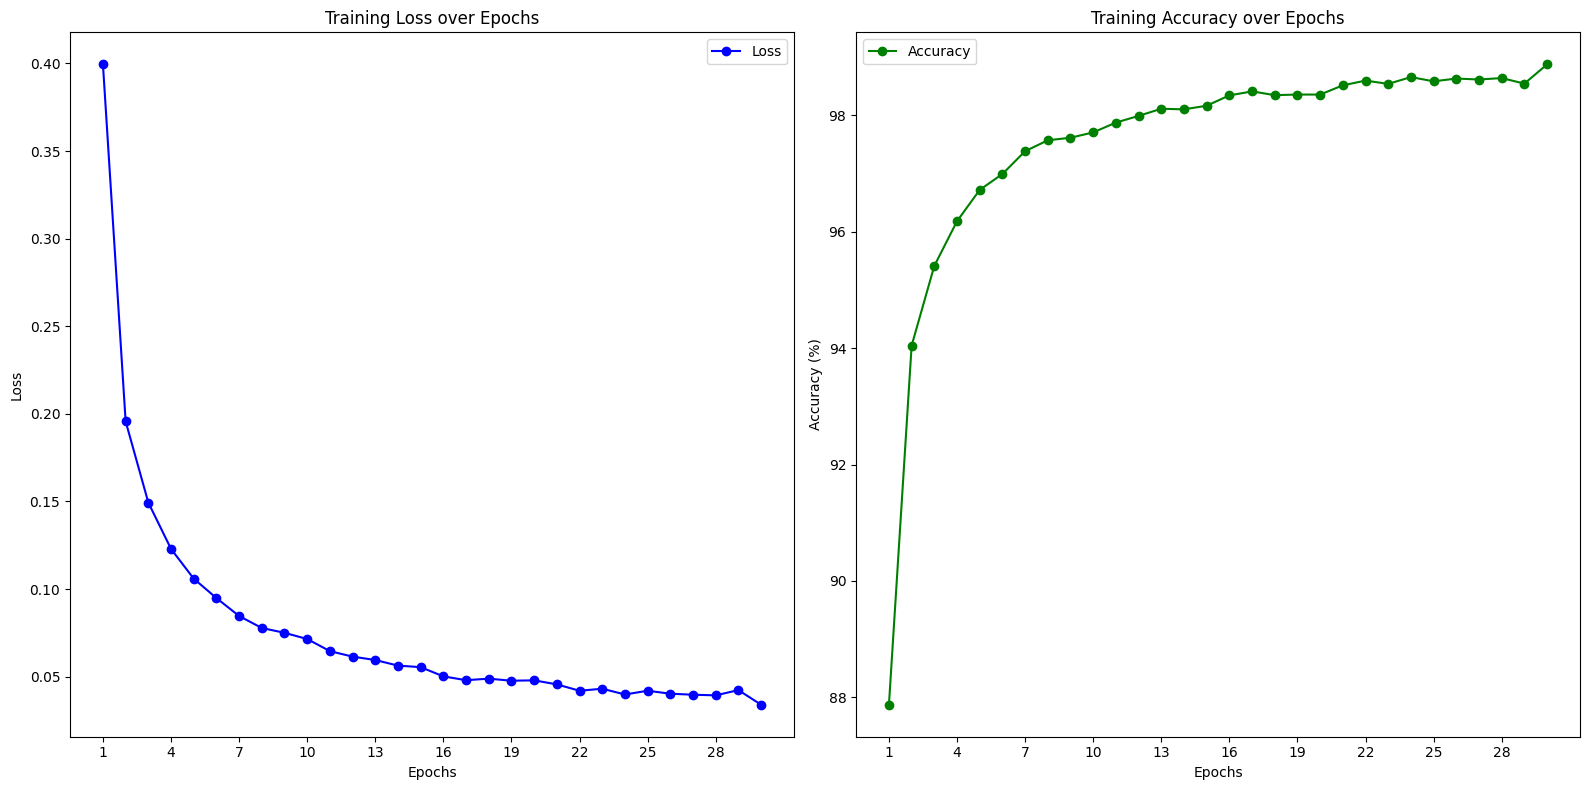

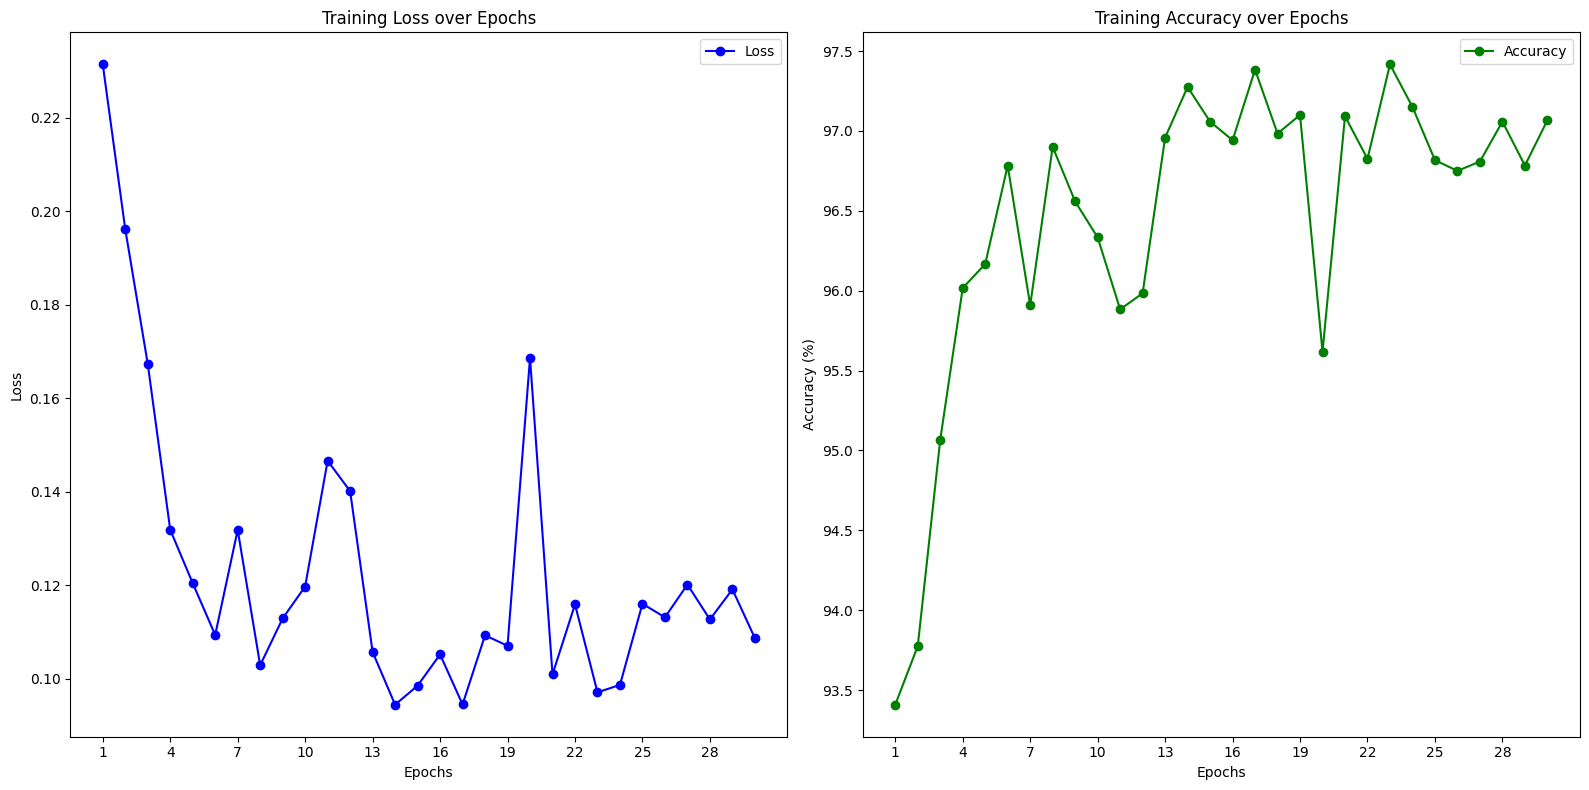

97.47

In [ ]:
# Plot train results
plot_training_results(L2reg_train_losses, L2reg_train_accuracies, epochs=30)
# Plot validation results
plot_training_results(L2reg_val_losses, L2reg_val_accuracies, epochs=30)
# Evaluation
evaluate_model(L2reg_model, test_loader, criterion)

## Mini-Batch Gradient Descent

In [ ]:
batch_sizes = [32, 64, 128]
results = {}

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")

    # Data loaders for current batch size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Model, criterion, optimizer
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Train the model and save results
    model, train_losses, train_accuracies, val_losses, val_accuracies, epoch_times = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=30
    )
    results[batch_size] = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "epoch_times": epoch_times
    }




Training with batch size: 32
Epoch [1/30], Train Loss: 0.3971, Train Acc: 87.99%, Val Loss: 0.2805, Val Acc: 91.38%
Epoch [2/30], Train Loss: 0.1977, Train Acc: 93.86%, Val Loss: 0.1545, Val Acc: 95.31%
Epoch [3/30], Train Loss: 0.1509, Train Acc: 95.32%, Val Loss: 0.1785, Val Acc: 94.40%
Epoch [4/30], Train Loss: 0.1224, Train Acc: 96.21%, Val Loss: 0.1314, Val Acc: 96.01%
Epoch [5/30], Train Loss: 0.1054, Train Acc: 96.70%, Val Loss: 0.1279, Val Acc: 95.85%
Epoch [6/30], Train Loss: 0.0954, Train Acc: 96.97%, Val Loss: 0.1251, Val Acc: 96.10%
Epoch [7/30], Train Loss: 0.0864, Train Acc: 97.24%, Val Loss: 0.1101, Val Acc: 96.52%
Epoch [8/30], Train Loss: 0.0764, Train Acc: 97.64%, Val Loss: 0.1103, Val Acc: 96.59%
Epoch [9/30], Train Loss: 0.0714, Train Acc: 97.73%, Val Loss: 0.1034, Val Acc: 96.86%
Epoch [10/30], Train Loss: 0.0689, Train Acc: 97.81%, Val Loss: 0.0922, Val Acc: 97.17%
Epoch [11/30], Train Loss: 0.0592, Train Acc: 98.08%, Val Loss: 0.1298, Val Acc: 96.24%
Epoch [12/3

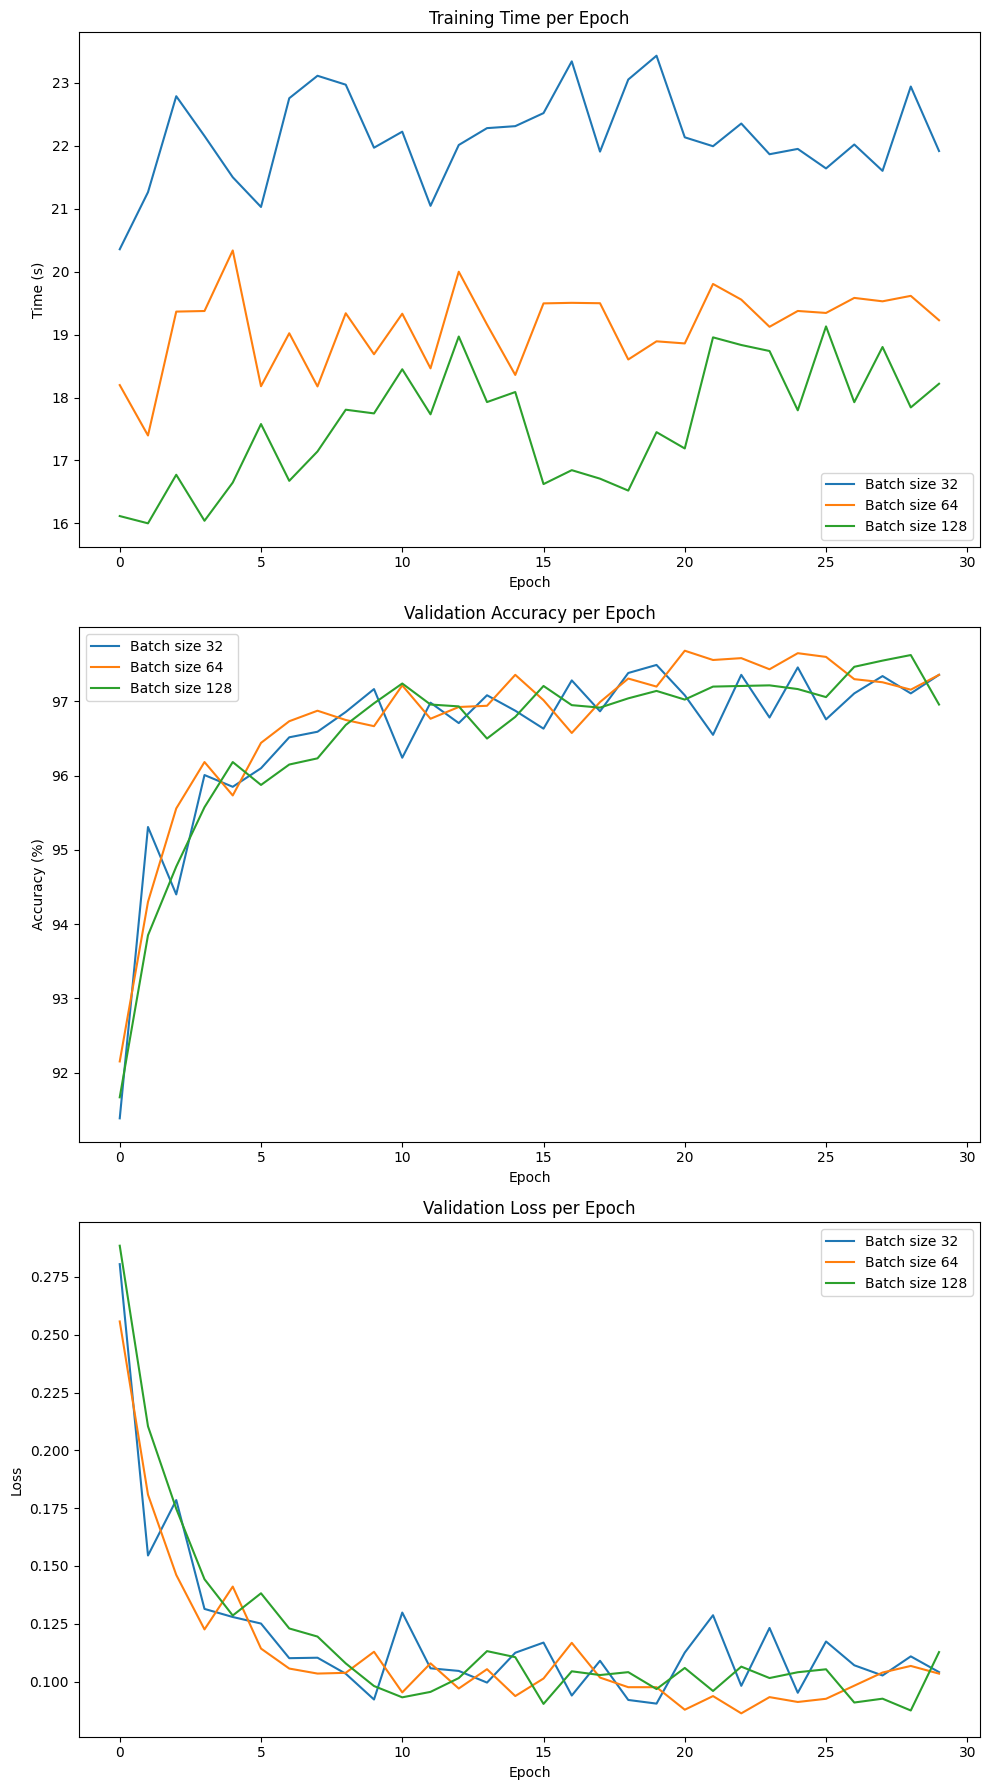

In [ ]:
# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 18))
for batch_size in batch_sizes:
    axes[0].plot(results[batch_size]['epoch_times'], label=f'Batch size {batch_size}')
    axes[1].plot(results[batch_size]['val_accuracies'], label=f'Batch size {batch_size}')
    axes[2].plot(results[batch_size]['val_losses'], label=f'Batch size {batch_size}')

axes[0].set_title('Training Time per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Time (s)')
axes[0].legend()

axes[1].set_title('Validation Accuracy per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()

axes[2].set_title('Validation Loss per Epoch')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()
plt.show()